In [1]:
#import libraries 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# MNIST IMAGE --> Tensor 

In [6]:
transform = transforms.ToTensor()

In [7]:
train_data = datasets.MNIST(root='data/', train=True, download=True, transform=transform)

In [8]:
test_data = datasets.MNIST(root='data/', train=False, download=True, transform=transform)

In [9]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [10]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: ToTensor()

In [11]:
# show a sample

In [12]:
image, label = train_data[0]

In [13]:
label

5

In [14]:
image.shape

torch.Size([1, 28, 28])

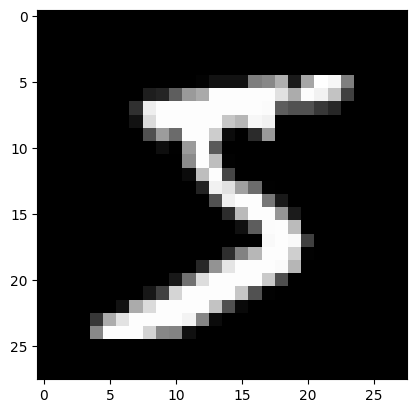

In [15]:
plt.imshow(image.reshape(28,28), cmap='gray') #reverse gist_yarg

In [16]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [17]:
# show samples from loader

In [18]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # FORMATTING

In [19]:
# FIRST BATCH
for image, label in train_loader:
    break

In [20]:
image.shape #first batch 

torch.Size([100, 1, 28, 28])

Lables:  [   7    2    3    5    8    5    3    6    9    9    1    3]


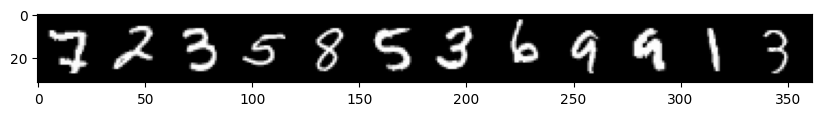

In [21]:
# Print the first 12 labels
print("Lables: ", label[:12].numpy())

# print the first 12 images
im = make_grid(image[:12], nrow=12)
plt.figure(figsize=(10,4))
# transpose the image from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1,2,0)));

In [22]:
# Model Building

In [23]:
class Model(nn.Module):
    def __init__(self, in_feature=28*28, out_feature=10, layers=[120,84]):
        super().__init__()
        
        self.fc1 = nn.Linear(in_feature, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_feature)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        y_pred = F.log_softmax(x, dim=1) # Milti Class Classification
        return y_pred

In [24]:
torch.manual_seed(101)
model = Model()
model

Model(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
# ANN ----> CNN
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [26]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
image.shape  # ---- > [100, 28*28]

torch.Size([100, 1, 28, 28])

In [28]:
image.view(100,-1).shape

torch.Size([100, 784])

In [29]:
# Training Model

In [30]:
import time 
st = time.time()

# Training
epochs = 10 

# Trackers
train_losses = []
test_loss = []
train_correct = []
test_correct = []

for i in range(1, epochs+1):
    
    trn_corr = 0
    tst_corr = 0 
    
    for batch_num, (X_train, y_train) in enumerate(train_loader, 1):
        
        # 10 Neurons
        # [0.1, 00.0, ....., 0.8] ----> 9
        y_pred = model(X_train.view(100,-1))
        
        
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr +=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_num%200 == 0:
            acc = trn_corr.item()*100/(100*batch_num)
            print(f'Epoch: {i} Batch: {batch_num} Loss: {loss.item()} Accuracy: {acc}')
            
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr)

    with torch.no_grad():
        for batch_num, (X_test, y_test) in enumerate (test_loader, 1):
            y_val = model(X_test.view(500,-1))
            predicted = torch.max(y_val.data,1)[1]
            tst_corr  += (predicted==y_test).sum()
        
        loss = criterion(y_val, y_test)
        test_loss.append(loss.item())
        test_correct.append(tst_corr)

print(f"Total Time: {(time.time()-st)/60:.2f} mins")

Epoch: 1 Batch: 200 Loss: 0.31175071001052856 Accuracy: 73.635
Epoch: 1 Batch: 400 Loss: 0.37453755736351013 Accuracy: 82.28
Epoch: 1 Batch: 600 Loss: 0.1612907350063324 Accuracy: 85.71666666666667
Epoch: 2 Batch: 200 Loss: 0.297218918800354 Accuracy: 93.785
Epoch: 2 Batch: 400 Loss: 0.13507138192653656 Accuracy: 94.0
Epoch: 2 Batch: 600 Loss: 0.12411658465862274 Accuracy: 94.32333333333334
Epoch: 3 Batch: 200 Loss: 0.1533873975276947 Accuracy: 95.465
Epoch: 3 Batch: 400 Loss: 0.07032603025436401 Accuracy: 95.5825
Epoch: 3 Batch: 600 Loss: 0.10482154041528702 Accuracy: 95.65666666666667
Epoch: 4 Batch: 200 Loss: 0.16745145618915558 Accuracy: 96.615
Epoch: 4 Batch: 400 Loss: 0.11194158345460892 Accuracy: 96.5125
Epoch: 4 Batch: 600 Loss: 0.05645017325878143 Accuracy: 96.62333333333333
Epoch: 5 Batch: 200 Loss: 0.1465216726064682 Accuracy: 97.36
Epoch: 5 Batch: 400 Loss: 0.07307665050029755 Accuracy: 97.2
Epoch: 5 Batch: 600 Loss: 0.08703742921352386 Accuracy: 97.245
Epoch: 6 Batch: 200 

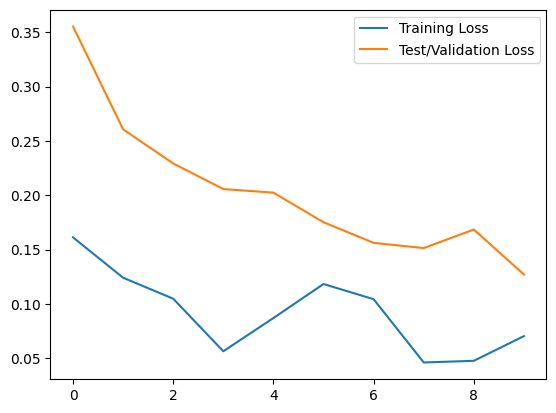

In [32]:
# evaluation

plt.plot(train_losses, label='Training Loss')
plt.plot(test_loss, label='Test/Validation Loss')
plt.legend()

In [39]:
train_acc = [t/600 for t in train_correct]
train_acc

[tensor(85.7167),
 tensor(94.3233),
 tensor(95.6567),
 tensor(96.6233),
 tensor(97.2450),
 tensor(97.6667),
 tensor(97.9617),
 tensor(98.2800),
 tensor(98.5217),
 tensor(98.7183)]

In [40]:
test_acc = [t/100 for t in test_correct]
test_acc

[tensor(93.2400),
 tensor(94.9000),
 tensor(96.0200),
 tensor(96.3600),
 tensor(96.8400),
 tensor(96.8100),
 tensor(97.4100),
 tensor(97.3200),
 tensor(97.1700),
 tensor(97.7400)]

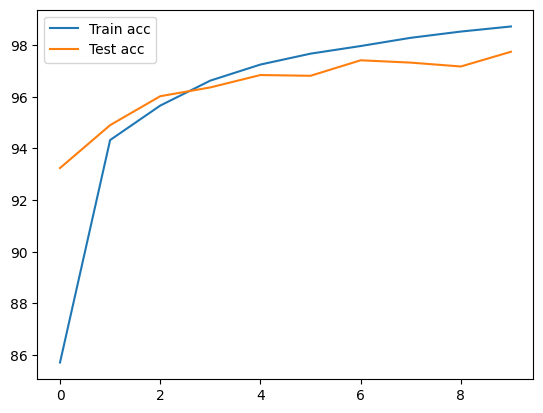

In [42]:
plt.plot(train_acc, label='Train acc')
plt.plot(test_acc, label='Test acc')
plt.legend();

In [44]:
# NEW UNSEEN DATA

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [58]:
with torch.no_grad():
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.argmax(y_val,1)[1]
        correct += (predicted==y_test).sum()

In [59]:
correct

tensor(1032)